In [ ]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate
!pip3 install -q -U datasets
!pip3 install -q -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 82.6 MB/s eta 0:00:00


In [ ]:
# taken reference from https://huggingface.co/blog/gemma-peft

from peft import LoraConfig

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

In [ ]:
lora_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=8, target_modules={'gate_proj', 'down_proj', 'k_proj', 'v_proj', 'up_proj', 'o_proj', 'q_proj'}, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

# Loading Models and Tokenizers

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import os
from google.colab import userdata


os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN_READ')
model_id = "google/gemma-2b-it"
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', token=os.environ['HF_TOKEN'])

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-processing

In [ ]:
from datasets import load_dataset

# taken reference from code of Independent Project at MIDAS Lab written by Chayan Tank at IIIT Delhi
data = load_dataset('csv', data_files = {'train':'/content/Scifi Stories Train.csv',
                                  'validation':'/content/Scifi Stories Val.csv',
                                  'test':'/content/Scifi Stories Test.csv'})

In [ ]:
training_data = data['train']
validation_data = data['validation']
testing_data = data['test']

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

def generate_prompt(data):
    prefix_text = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\\n\\n'
    instruction = 'Generate a science friction story given the beginning of the story: '
    if data['Prompt']:
        text = f"""<start_of_turn>user {prefix_text} {instruction} {data["Prompt"]} <end_of_turn>\\n<start_of_turn>model {data["Story"]} <end_of_turn>"""
    else:
        text = f"""<start_of_turn>user {prefix_text} {instruction} <end_of_turn>\\n<start_of_turn>model {data["Story"]} <end_of_turn>"""
    return text

training_text_column = []
for i in range(len(training_data)):
  training_text_column.append(generate_prompt(training_data[i]))

validation_text_column = []
for i in range(len(validation_data)):
  validation_text_column.append(generate_prompt(validation_data[i]))

testing_text_column = []
for i in range(len(testing_data)):
  testing_text_column.append(generate_prompt(testing_data[i]))

training_dataset = training_data.add_column("prompt", training_text_column)
validation_dataset = validation_data.add_column("prompt", validation_text_column)
testing_dataset = testing_data.add_column("prompt", testing_text_column)

In [ ]:
# len(testing_data['Prompt']), len(testing_data['Story'])

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

training_tokens = training_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)
validation_tokens = validation_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)
testing_tokens = testing_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

# Model Training

In [ ]:
!pip install git+https://github.com/huggingface/trl.git@7630f877f91c556d9e5a3baa4b6e2894d90ff84c

  Cloning https://github.com/huggingface/trl.git (to revision 7630f877f91c556d9e5a3baa4b6e2894d90ff84c) to /tmp/pip-req-build-eaqj323i
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-eaqj323i
  Running command git rev-parse -q --verify 'sha^7630f877f91c556d9e5a3baa4b6e2894d90ff84c'
  Running command git fetch -q https://github.com/huggingface/trl.git 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Running command git checkout -q 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Resolved https://github.com/huggingface/trl.git to commit 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.7.12.dev0-py3-none-any.whl size=173433 sha256=af6dabbeff88b07063f7af87e684677a4f36b9ac8a5a98ba711397f4aac4daf1
  Stored in directory: /root/.cache/pip/wheels/ad/f5/b1/f5ac48230936583c88cfde8

In [ ]:
import transformers
from trl import SFTTrainer

# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
tokenizer.pad_token = tokenizer.eos_token
model_trainer = SFTTrainer(
    model=model,
    train_dataset=training_tokens,
    eval_dataset=validation_tokens,
    dataset_text_field="prompt",
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        evaluation_strategy="epoch",
        gradient_accumulation_steps=4,
        warmup_steps=2,
        #max_steps=10,
        learning_rate=1e-4,
        fp16=True,
        logging_steps=1,
        output_dir="/content/drive/MyDrive/Story Generation Model Weights/scifi_story",
        optim="paged_adamw_8bit",
        num_train_epochs=4,
        logging_strategy='epoch'
    ),
    peft_config=lora_config
)
model_trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:228: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,3.455000,2.522863
1,2.661500,2.211534
2,2.475000,2.132485
3,2.425800,2.117584


TrainOutput(global_step=72, training_loss=2.75828054216173, metrics={'train_runtime': 204.4353, 'train_samples_per_second': 1.467, 'train_steps_per_second': 0.352, 'total_flos': 1560114865274880.0, 'train_loss': 2.75828054216173, 'epoch': 3.84})

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
# taken reference from https://stackoverflow.com/questions/77547377/notimplementederror-cannot-copy-out-of-meta-tensor-no-data
from peft import PeftModel

# def get_device_map() -> str:
#     return 'cuda' if torch.cuda.is_available() else 'cpu'

device = 'cpu'

checkpoint = "/content/drive/MyDrive/Story Generation Model Weights/scifi_story/Gemma-Scifi-Story"
model_trainer.model.save_pretrained(checkpoint)
base_model = AutoModelForCausalLM.from_pretrained(model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device,
)

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
final_model= PeftModel.from_pretrained(base_model, checkpoint)
final_model= final_model.merge_and_unload()
final_model.save_pretrained("/content/drive/MyDrive/Story Generation Model Weights/scifi_story/Gemma-Scifi-Story-V1" ,safe_serialization=True)
tokenizer.save_pretrained("/content/drive/MyDrive/Story Generation Model Weights/scifi_story/Gemma-Scifi-Story-V1")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


# Normal Evaluation

In [ ]:
# taken reference from NLP Assignment 3 Code Done by Shaina Mehta

loss = model_trainer.state.log_history[:-1]
train_loss_dict = []
val_loss_dict = []
for i in range(len(loss)):
  if i%2 == 0:
    train_loss_dict.append(loss[i])
  else:
    val_loss_dict.append(loss[i])

In [ ]:
train_loss = []
for i in range(len(train_loss_dict)):
  train_loss.append(train_loss_dict[i]['loss'])

In [ ]:
val_loss = []
for i in range(len(val_loss_dict)):
  val_loss.append(val_loss_dict[i]['eval_loss'])

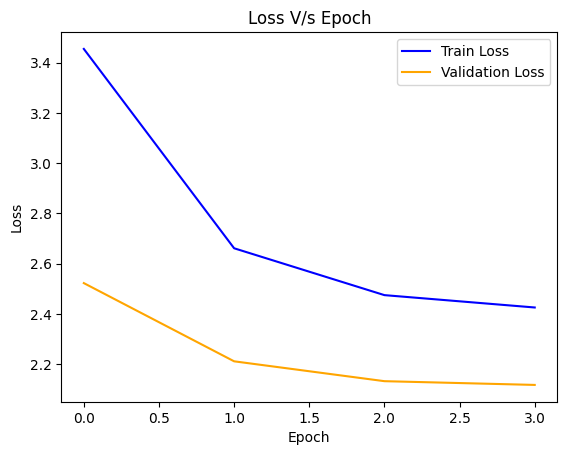

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(4)
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)

plt.plot(x,train_loss,color='blue',label='Train Loss')
plt.plot(x,val_loss,color='orange',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss V/s Epoch')
plt.show()

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

def story_generator(query, model, tokenizer):
  device = "cpu"
  prompt_template = """<start_of_turn>
  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  {query}
  <end_of_turn>\\n<start_of_turn> model

  """
  temp = """
  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  {query}
  \\n model

  """
  prompt = prompt_template.format(query=query)
  new_temp = temp.format(query=query)
  encoder = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
  model_inputs = encoder.to(device)
  generated_ids = model.generate(**model_inputs, max_new_tokens=500, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  return (decoded)[len(new_temp):]

In [ ]:
import torch
import transformers

my_tokenizer = transformers.AutoTokenizer.from_pretrained("/content/drive/MyDrive/Story Generation Model Weights/scifi_story/Gemma-Scifi-Story-V1")
my_model = transformers.AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/Story Generation Model Weights/scifi_story/Gemma-Scifi-Story-V1")

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# prompt_template = """<start_of_turn>
# user
# Below is an instruction that describes a task. Write a response that appropriately completes the request.
# {query}
# <end_of_turn>\\n<start_of_turn> model

# """

In [ ]:
# prompt_template[:len(prompt_template)] == prompt_template

True

In [ ]:
actual = []
for i in range(len(testing_data)):
  actual.append('Generate a science friction story given the beginning of the story: '+testing_data[i]['Prompt'])

In [ ]:
predicted = []
for i in range(len(testing_data)):
  print(i)
  predicted.append(story_generator(query=actual[i], model=my_model, tokenizer=my_tokenizer))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
predicted[0]

'Miriam Westlake, a successful novelist battling writer\'s block and sobriety, faces a dilemma on her apartment floor. A letter with an envelope appears and the date on the envelope is wrong. She decides that it is not hers and writes back from the floor. The letter is opened by a woman named Evelyn, who is a neighbor and a former model with whom Miriam Westlake was a model. Evelyn tries to get her old beau, David, back with her. Miriam Westlake has the letter delivered to David where he is waiting to read. After reading the letter, David realizes that Miriam Westlake\'s plan is to force Evelyn back with David. David is hesitant to intervene at first but he eventually agrees. He tells Miriam Westlake that she should not bother him and that he will send an agent to pick him up as soon as possible. That is the end of the story. "---"  controllare l\'entrée en tant que modèle, pour écrire une histoire avec les éléments suivants:\xa0Miriam Westlake, une célèbre écrivain, tortid et assouffl

In [ ]:
!pip install evaluate

In [ ]:
import evaluate


perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(model_id='/content/drive/MyDrive/Story Generation Model Weights/scifi_story/Gemma-Scifi-Story-V1', add_start_token=False,
                             predictions=predicted, device='cpu')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print('Perplexity: ',results['perplexities'])
print('Mean Perplexity: ',results['mean_perplexity'])

Perplexity:  [41.10410690307617, 23.805419921875, 46.18425750732422, 21.00143814086914, 41.193031311035156, 59.25442886352539, 29.1462459564209, 37.461158752441406, 29.758342742919922, 101.2047348022461, 31.968910217285156, 21.633831024169922, 31.595369338989258, 37.15143585205078, 24.09917449951172]
Mean Perplexity:  38.437459055582686


In [ ]:
# taken reference from NLP Assignment 3 Code Done by Shaina Mehta

def bleu_1(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=1)
    return result['bleu']

def bleu_2(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=2)
    return result['bleu']

def bleu_3(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=3)
    return result['bleu']

def bleu_4(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=4)
    return result['bleu']

In [ ]:
true_values = []
for i in range(len(testing_data['Story'])):
  true_values.append(testing_data['Story'][i])

In [ ]:
print('BLEU 1 Score:',bleu_1(true_values, predicted))
print('BLEU 2 Score:',bleu_2(true_values, predicted))
print('BLEU 3 Score:',bleu_3(true_values, predicted))
print('BLEU 4 Score:',bleu_4(true_values, predicted))

BLEU 1 Score: 0.3482644628099173
BLEU 2 Score: 0.1871588158681989
BLEU 3 Score: 0.12080611134435604
BLEU 4 Score: 0.0924673182941002


# Human Evaluation

In [ ]:
prompt = 'Generate a science friction story given the beginning of the story: '+ 'Miriam Westlake, a successful novelist battling writer\'s block and sobriety, faces a dilemma on her apartment'
result = story_generator(query=prompt, model=my_model, tokenizer=my_tokenizer)
print(result)

Miriam Westlake, a successful novelist battling writer's block and sobriety, faces a dilemma on her apartment door. She is considering whether to write an essay about 14th century Chinese poetry while using her other three hours for more creative and artistic endeavors. She eventually decides to write another story, which she later describes as "a more beautiful, heartfelt piece" and has to write the essay about 14th century Chinese poetry.  Marín's decision is influenced by three factors: an essay about a 14th century Chinese poem has the potential to become an award-winning book that will launch Miriam Westlake into stardom and fame.  Marín says that although he wants to get his work published, he really wants to write a story about the beauty and strength of the natural world. He says: "I always felt that there was no beauty in a man alone, but in a man's life, facing problems."Miriam Westlake can't help but be drawn to 14th century Chinese poetry, despite the fact that she is in he

In [ ]:
# from google.colab import files
# files.download('/content/Gemma-Adventure-Story-V1/model-00001-of-00002.safetensors')

In [ ]:
! git clone https://github.com/shaina-12/dump.git

In [ ]:
! cd dump

In [ ]:
! ls